<a href="https://colab.research.google.com/github/hpatryck/Processamento-Digital-de-Imagem/blob/main/Atividade_6_Utiliza%C3%A7%C3%A3o_do_OCR_Tesseract_com_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr

# Instalação de bibliotecas no Google Colaboratory.

!pip install Pillow
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
#!pip install pytesseract
import pytesseract
from skimage import io

pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

print("OpenCV-Python Version {}".format(cv2.__version__))

from google.colab import drive
drive.mount('/content/drive')

OpenCV-Python Version 4.10.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


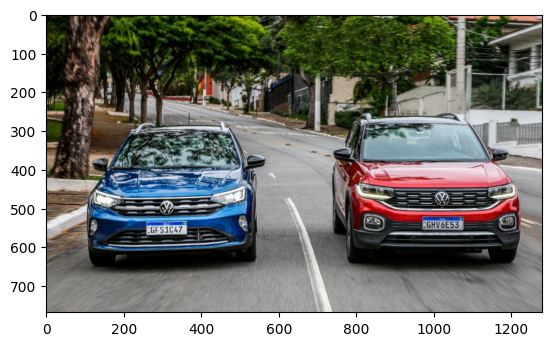

In [ ]:
image = io.imread(r'/content/drive/MyDrive/Colab Notebooks/placa.jpg')

io.imsave('placa.jpg', image)

# loading the image from the disk
image = cv2.imread('placa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

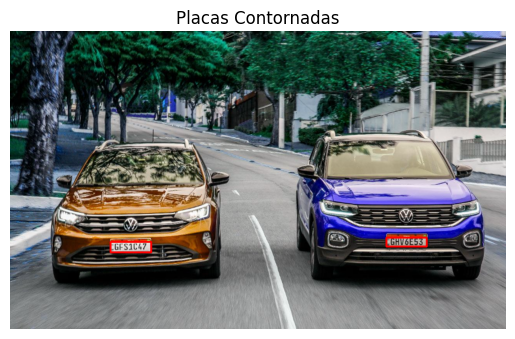

In [ ]:
# Verificar se a imagem foi carregada corretamente
if image is None:
    print("Erro ao carregar a imagem. Verifique o caminho.")
else:
    # Converter a imagem para o espaço de cores HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir o intervalo de cores para isolar as placas (branco)
    lower_white = np.array([0, 0, 180], dtype=np.uint8)
    upper_white = np.array([255, 80, 255], dtype=np.uint8)

    # Criar uma máscara para a cor branca (placas de fundo branco)
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Aplicar um desfoque para suavizar a imagem
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)

    # Detectar bordas na máscara
    edged = cv2.Canny(blurred, 50, 200)

    # Encontrar os contornos na imagem
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Função para verificar se um contorno pode ser a placa (aspecto e área)
    def is_plate_contour(contour):
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)  # Razão de aspecto da placa
        area = cv2.contourArea(contour)  # Área do contorno
        return 2 < aspect_ratio < 6 and 1000 < area < 15000  # Ajuste os valores conforme necessário

    # Filtrar os contornos que podem ser placas
    plate_contours = [c for c in contours if is_plate_contour(c)]

    # Garantir que encontrou contornos de placas
    if plate_contours:
        # Desenhar retângulos ao redor das possíveis placas
        for contour in plate_contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 3)  # Desenhar retângulo verde
    else:
        print("Nenhuma placa foi encontrada.")

    # Exibir a imagem com as placas contornadas
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Placas Contornadas')
    plt.axis('off')  # Desligar os eixos para melhor visualização
    plt.show()


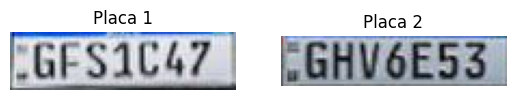

In [ ]:
# Função para verificar sobreposição de dois retângulos
def is_overlapping(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    return not (x1 > x2 + w2 or x1 + w1 < x2 or y1 > y2 + h2 or y1 + h1 < y2)

# Função para recortar as placas da imagem
def extract_plates(image):
    # Converter a imagem para o espaço de cores HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir o intervalo de cores para isolar as placas (branco)
    lower_white = np.array([0, 0, 180], dtype=np.uint8)
    upper_white = np.array([255, 80, 255], dtype=np.uint8)

    # Criar uma máscara para a cor branca (placas de fundo branco)
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Aplicar um desfoque para suavizar a imagem
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)

    # Detectar bordas na máscara
    edged = cv2.Canny(blurred, 50, 200)

    # Encontrar os contornos na imagem
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar os contornos que podem ser placas
    plate_contours = [c for c in contours if is_plate_contour(c)]

    # Recortar as placas encontradas e armazenar as imagens
    plate_images = []
    bounding_rects = []

    for contour in plate_contours:
        x, y, w, h = cv2.boundingRect(contour)
        current_rect = (x, y, w, h)

        # Verificar se há sobreposição com placas já recortadas
        if all(not is_overlapping(current_rect, existing_rect) for existing_rect in bounding_rects):
            plate_image = image[y:y+h, x:x+w]
            plate_images.append(plate_image)
            bounding_rects.append(current_rect)  # Adicionar retângulo atual à lista para evitar duplicatas

    return plate_images


# Carregar a imagem enviada
image = cv2.imread('placa.jpg')

# Verificar se a imagem foi carregada corretamente
if image is None:
    print("Erro ao carregar a imagem. Verifique o caminho.")
else:
    # Extrair as placas da imagem
    plates = extract_plates(image)

    # Exibir as placas recortadas
    for i, plate in enumerate(plates):
        plt.subplot(1, len(plates), i+1)
        plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        plt.title(f'Placa {i+1}')
        plt.axis('off')

    plt.show()


Texto da Placa 1: PGESI047—
Texto da Placa 2: SGHY6GE53


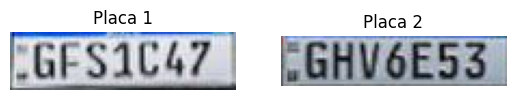

In [ ]:
# Função para verificar se um contorno pode ser a placa (aspecto e área)
def is_plate_contour(contour):
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)  # Razão de aspecto da placa
    area = cv2.contourArea(contour)  # Área do contorno
    return 2 < aspect_ratio < 6 and 1000 < area < 15000  # Ajuste os valores conforme necessário

# Função para verificar sobreposição de dois retângulos
def is_overlapping(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    return not (x1 > x2 + w2 or x1 + w1 < x2 or y1 > y2 + h2 or y1 + h1 < y2)

# Função para recortar as placas da imagem
def extract_plates(image):
    # Converter a imagem para o espaço de cores HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir o intervalo de cores para isolar as placas (branco)
    lower_white = np.array([0, 0, 180], dtype=np.uint8)
    upper_white = np.array([255, 80, 255], dtype=np.uint8)

    # Criar uma máscara para a cor branca (placas de fundo branco)
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Aplicar um desfoque para suavizar a imagem
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)

    # Detectar bordas na máscara
    edged = cv2.Canny(blurred, 50, 200)

    # Encontrar os contornos na imagem
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar os contornos que podem ser placas
    plate_contours = [c for c in contours if is_plate_contour(c)]

    # Recortar as placas encontradas e armazenar as imagens
    plate_images = []
    bounding_rects = []

    for contour in plate_contours:
        x, y, w, h = cv2.boundingRect(contour)
        current_rect = (x, y, w, h)

        # Verificar se há sobreposição com placas já recortadas
        if all(not is_overlapping(current_rect, existing_rect) for existing_rect in bounding_rects):
            plate_image = image[y:y+h, x:x+w]
            plate_images.append(plate_image)
            bounding_rects.append(current_rect)  # Adicionar retângulo atual à lista para evitar duplicatas

    return plate_images

# Função para extrair texto das placas usando Tesseract
def extract_text_from_plate(plate_image):
    # Converter para escala de cinza
    gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

    # Aplicar um filtro de desfoque adaptativo
    blurred = cv2.adaptiveThreshold(gray_plate, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Aplicar um detector de bordas Canny com parâmetros ajustados
    edged = cv2.Canny(blurred, 50, 200)

    # Aplicar limiarização para destacar os caracteres
    _, thresh_plate = cv2.threshold(gray_plate, 150, 255, cv2.THRESH_BINARY)

    # Extrair texto da imagem da placa
    text = pytesseract.image_to_string(thresh_plate, config='--psm 8')  # PSM 8 é ideal para texto curto (placas)
    return text.strip()


        # Utilizando o EasyOCR
    reader = Reader(['en'])  # Substitua 'en' pelo idioma das placas
    results = reader.readtext(plate_image)

    # Extraindo o texto com a maior confiança
    if results:
        text = results[0][-1]
        return text
    else:
        return "Texto não encontrado"

# Carregar a imagem enviada
image = cv2.imread('placa.jpg')

# Verificar se a imagem foi carregada corretamente
if image is None:
    print("Erro ao carregar a imagem. Verifique o caminho.")
else:
    # Extrair as placas da imagem
    plates = extract_plates(image)

    # Exibir as placas recortadas e extrair o texto
    for i, plate in enumerate(plates):
        plt.subplot(1, len(plates), i+1)
        plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        plt.title(f'Placa {i+1}')
        plt.axis('off')

        # Extrair texto da placa
        text = extract_text_from_plate(plate)
        print(f'Texto da Placa {i+1}: {text}')

    plt.show()
